In [243]:
from jsonobject import *
import numpy as np 
import random
import math
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import deepcopy

In [192]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10] 

In [11]:
random.seed(2021)

# Classes

In [12]:
# Convolution
class Convolution(JsonObject):
    name = StringProperty()
    kernel = IntegerProperty()
    padding = StringProperty()
    stride = IntegerProperty()
    nb_filter = IntegerProperty()
    fct_activation = StringProperty()

In [13]:
# Input 
class InputLayer(JsonObject):
    name = "I"
    shape = ListProperty(int)
    #shape = StringProperty()

In [14]:
# Pooling Avg/Max
class Pooling(JsonObject):
    name = StringProperty()
    op = StringProperty()
    kernel = IntegerProperty(default=2)
    padding = StringProperty(default="'valid'")
    stride = IntegerProperty(default=None)

In [15]:
# Class Flatten
class Flatten(JsonObject):
    name = "F"

In [16]:
# Dense --> Fully connected layer
class Dense(JsonObject):
    name = StringProperty()
    nb_neurones =  IntegerProperty()
    fct_activation = StringProperty()

# Test Graph

In [17]:
G = nx.Graph()

In [18]:
G.add_node("C1")
G.add_node("C2")
G.add_edge("C1","C2")
G.add_edge("C2","P1")
G.add_edge("P1","C3")
G.add_edge("C3","C4")
G.add_edge("C2","C4")
G.add_edge("C4","C5")

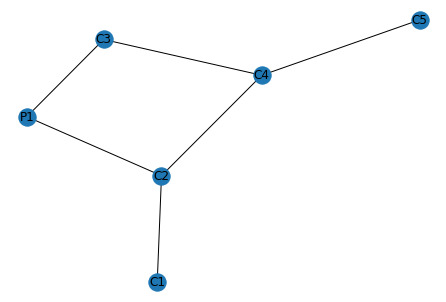

In [19]:
nx.draw(G, with_labels=True)
plt.show()

In [20]:
data = nx.node_link_data(G)

In [21]:
data

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 'C1'},
  {'id': 'C2'},
  {'id': 'P1'},
  {'id': 'C3'},
  {'id': 'C4'},
  {'id': 'C5'}],
 'links': [{'source': 'C1', 'target': 'C2'},
  {'source': 'C2', 'target': 'P1'},
  {'source': 'C2', 'target': 'C4'},
  {'source': 'P1', 'target': 'C3'},
  {'source': 'C3', 'target': 'C4'},
  {'source': 'C4', 'target': 'C5'}]}

# Value

In [22]:
layers_name = [Convolution, InputLayer, Pooling, Flatten, Dense]

# Table of hyperparameter value
kernel_value = [1, 2, 3, 4, 5, 6, 7]
stride_value = [1, 2, 3]
padding_value = ["valid", "same"]
#nb_filter_value = [6, 16, 64, 128, 256, 512, 1024, 2048]
fct_activation_value = ["tanh", "relu", "selu"]


nb_class = 10 # nb_class
op_value = ['avg',"max"]

# Function

In [23]:
def stop(size_archi, x):
    prob = x*size_archi-1*x
    if ( prob < random.randrange(101)):
        return True
    else : return False

In [229]:
def create_json_file(archi, graph_json, file_name):
    directory = 'architecture_json/'
    
    # reset file
    archi_file = open(directory+file_name, "w")
    archi_file.close()
    
    # create file
    
    # open file
    archi_file = open(directory+file_name, "a")
    
    archi_file.write("""[{
    """)
    
    archi_file.write("""\t"graph":""")
    archi_file.write(json.dumps(graph_json))
    archi_file.write(""",""")
    archi_file.write("""
    \t"archi":[
    """)
    
    archi_size = len(archi)
    i = 0
    for l in archi:

        str_layer = """\t{
            'class':'"""
        str_layer += l.__class__.__name__
        str_layer +="""',\n\t\t\t'parameters':"""
        str_layer += str(l.to_json())
        str_layer += """\n\t\t}"""
        if(i < archi_size-1):
            str_layer += ""","""
            i+=1
        str_layer = str_layer.replace("'","\"")
        
        archi_file.write(str_layer)
        
    archi_file.write("""\n]}]""")
    archi_file.close()

In [114]:
def add_edge(G, archi, layer):
    list_nodes = list(G.nodes)
    if (len(list_nodes) > 0):
        G.add_edge(list_nodes[len(list_nodes)-1], layer['name'])
    else: 
        G.add_edge(archi[len(archi)-2]['name'], layer['name'])
    return G

In [115]:
# compute the output 
# valid vs same
def calcul_output(input_size, l):
    output_size = 0
    if(l.padding == "valid"):
        kernel = l.kernel
        stride = l.stride
        while(input_size>=kernel):
            input_size -= stride
            output_size += 1   
    else:
        stride = l.stride
        if(input_size%stride == 0):
            output_size = int(input_size/stride)
        else:
            output_size = int(input_size/stride)+1
    return output_size

In [116]:
# add layer to architecture 

def addLayer(archi, layer):
    input_size = archi[0].shape[0]
    feature_extra = archi[1:]
    
    # add layer if the architecture is empty
    if(feature_extra == []):
        archi.append(layer)
        return 1, archi, calcul_output(input_size,layer)
    
    else :
        # compute size of the output of the last layer
        for l in feature_extra: 
            output_size = calcul_output(input_size, l)
            input_size = output_size
        
        # if we couldn't reduce more
        if(input_size == 1):
            return 0, archi, input_size
        
        # if the output size got more than 1 we can add new layer
        elif(output_size > 1): 
            output_size = calcul_output(input_size, layer)
            
            # if output size got negate is that the layer we want to add is wrong
            if(output_size < 1 ):
                return -1, archi, input_size
            # if output size is bigger than 0 we can add new layer and continue
            elif(output_size > 0):
                archi.append(layer)
                return 1, archi, output_size
            # this should not append
            else:
                return "Somethink wrong"
    # this should not append
    return "Error"

In [251]:
def add_identity_block(archi, G, kernel, nb_layer, filters, nb_conv, padding, nb_add ):
    output = 0
    
    for i in range(0,nb_layer):
        conv = Convolution(
                name="C"+str(nb_conv),
                kernel=kernel[i], 
                padding=padding[i], 
                stride=1, 
                nb_filter= filters[i],
                fct_activation=fct_activation_value[random.randrange(3)]
            )
        code, archi, output = addLayer(archi, conv)
        G = add_edge(G, archi, conv)
        nb_conv+=1
    
    next_add = "add"+str(nb_add)
    prev_add = "add" +str(nb_add-1)
    if(nb_add == 1):
        G.add_edge(archi[len(archi)-(1+nb_layer)]['name'], next_add) # skip
        G.add_edge(archi[len(archi)-1]['name'], next_add) # merge with the last
    else:
        G.add_edge(prev_add, next_add) # skip
        G.add_edge(archi[len(archi)-1]['name'], next_add) # merge with the last
    return archi, G, nb_conv, output
    

In [244]:
def add_conv_block(archi, G, kernel, nb_layer, filters, nb_conv, padding, stride, nb_add):
    output = 0
    for i in range(0,nb_layer):
        conv = Convolution(
                name="C"+str(nb_conv),
                kernel=kernel[i], 
                padding=padding[i], 
                stride=stride[i], 
                nb_filter= filters[i],
                fct_activation=fct_activation_value[random.randrange(3)]
            )
        code, archi, output = addLayer(archi, conv)
        G = add_edge(G, archi, conv)
        nb_conv+=1
    
    next_add = "add"+str(nb_add)
    prev_add = "add"+str(nb_add-1)
    
    
    conv_res = deepcopy(archi[len(archi)-(1+nb_layer)])
    conv_res['name'] = "C"+str(nb_conv)
    
    archi.append(conv_res)
    
    G.add_edge(prev_add, conv_res['name'])
    
    G.add_edge(archi[len(archi)-2]['name'], next_add) # merge with the last
    G.add_edge(conv_res['name'], next_add) # skip
    nb_conv +=1
        
    return archi, G, nb_conv, output

# Creation d'architecture

In [248]:
# init
extraction_feature= [Pooling, Convolution]
nb_conv = 1
nb_pooling = 1
nb_dense = 1
nb_add = 0

architecture = list() # init architecture
G = nx.DiGraph() # init graph

nb_filter_value = 6*3 # init nb feature map
output_size = 32 

# add input Layer
architecture.append(InputLayer(shape=[32,32,3]))


# add extraction feature (succession of Pooling/convolution)
# Pooling can't be follow by a Pooling
pooling = True
code = 1 # we can add new layer
j = 2

kernel = 3

# add first conv

add_layer = Convolution(
    name="C"+str(nb_conv),
    kernel=7, 
    padding=padding_value[random.randrange(2)], 
    stride=2, 
    nb_filter= nb_filter_value,
    fct_activation=fct_activation_value[random.randrange(3)]
)

code, architecture, output_size = addLayer(architecture, add_layer)
nb_filter_value = nb_filter_value*j
G = add_edge(G, architecture, add_layer)
nb_conv += 1


# add first pooling

add_layer = Pooling(
    name="P"+str(nb_pooling),
    op = op_value[random.randrange(2)],
    kernel=kernel, 
    padding=padding_value[random.randrange(2)], 
    stride=2
)

code, architecture, output_size = addLayer(architecture, add_layer)
G = add_edge(G, architecture, add_layer)
nb_pooling += 1

# add identity layer
nb_add += 1
architecture, G, nb_conv, output_size = add_identity_block(architecture, G, [1,kernel], 2,
                                                           [nb_filter_value,nb_filter_value], 
                                                           nb_conv, ["same","same"], nb_add)
nb_filter_value = nb_filter_value*j

G.add_edge("add"+str(nb_add), ("C"+str(nb_conv)))

# add conv layer
nb_add += 1
architecture, G, nb_conv, output_size = add_conv_block(architecture, G, [1,kernel], 2, 
                                                       [nb_filter_value, nb_filter_value], 
                                                       nb_conv, ["same","same"], [2,1], nb_add)
nb_filter_value = nb_filter_value*j

G.add_edge("add"+str(nb_add), ("C"+str(nb_conv)))

# add identity layer
nb_add += 1
architecture, G, nb_conv, output_size = add_identity_block(architecture, G, [1,kernel], 2,
                                                           [nb_filter_value,nb_filter_value], 
                                                           nb_conv, ["same","same"], nb_add)
nb_filter_value = nb_filter_value*j
    
G.add_edge("add"+str(nb_add), ("C"+str(nb_conv)))

# add conv layer
nb_add += 1
architecture, G, nb_conv, output_size = add_conv_block(architecture, G, [1,kernel], 2, 
                                                       [nb_filter_value, nb_filter_value], 
                                                       nb_conv, ["same","same"], [2,1], nb_add)





try:
    nb_filter_value = architecture[len(architecture-1)-1]['nb_filter']
except:
    nb_filter_value = int(nb_filter_value/2)

print("output size : " + str(output_size))
print("nb_filter : " + str(nb_filter_value))
print("code: " + str(code))


f = Flatten()
architecture.append(f)
G.add_edge("add"+str(nb_add), f['name'])

# add dense Layer

param = output_size*output_size*(nb_filter_value)
print('param : ' + str(param))


## init values
pourcent = random.uniform(10,90)
nb=0
nb_neurones = int(param*pourcent/100)
    
print("nb_neurone : " + str(nb_neurones))
while(nb_neurones > nb_class):
    print("=====")
    print("iteration" + str(nb))
    print("nb_neurone : " + str(nb_neurones))
    
    dense = Dense(
        name = "D" + str(nb_dense),
        nb_neurones = nb_neurones,
        fct_activation = fct_activation_value[random.randrange(3)]
    )
    architecture.append(dense)
    G = add_edge(G, architecture, dense)
    
        
    #incrementation
    nb_dense += 1
    pourcent = random.uniform(10,90)
    nb+=1
    nb_neurones = int(nb_neurones*pourcent/100)


last_dense = Dense(
    name = "D" + str(nb_dense),
    nb_neurones = nb_class,
    fct_activation="softmax"           
)


architecture.append(last_dense)

G = add_edge(G, architecture, last_dense)

                        
# print architecture
print(architecture)

# create file
file_name = "archi_resnet_test.json"
print(file_name)
print("")
create_json_file(architecture, nx.node_link_data(G), file_name)

    
    
      

Convolution(fct_activation='selu', kernel=1, name='C2', nb_filter=36, padding='same', stride=1)
Convolution(fct_activation='selu', kernel=3, name='C3', nb_filter=36, padding='same', stride=1)
Convolution(fct_activation='relu', kernel=1, name='C7', nb_filter=144, padding='same', stride=1)
Convolution(fct_activation='relu', kernel=3, name='C8', nb_filter=144, padding='same', stride=1)
output size : 2
nb_filter : 144
code: 1
param : 576
nb_neurone : 74
=====
iteration0
nb_neurone : 74
=====
iteration1
nb_neurone : 12
[InputLayer(name='I', shape=[32, 32, 3]), Convolution(fct_activation='selu', kernel=7, name='C1', nb_filter=18, padding='valid', stride=2), Pooling(kernel=3, name='P1', op='avg', padding='valid', stride=2), Convolution(fct_activation='selu', kernel=1, name='C2', nb_filter=36, padding='same', stride=1), Convolution(fct_activation='selu', kernel=3, name='C3', nb_filter=36, padding='same', stride=1), Convolution(fct_activation='selu', kernel=1, name='C4', nb_filter=72, padding='

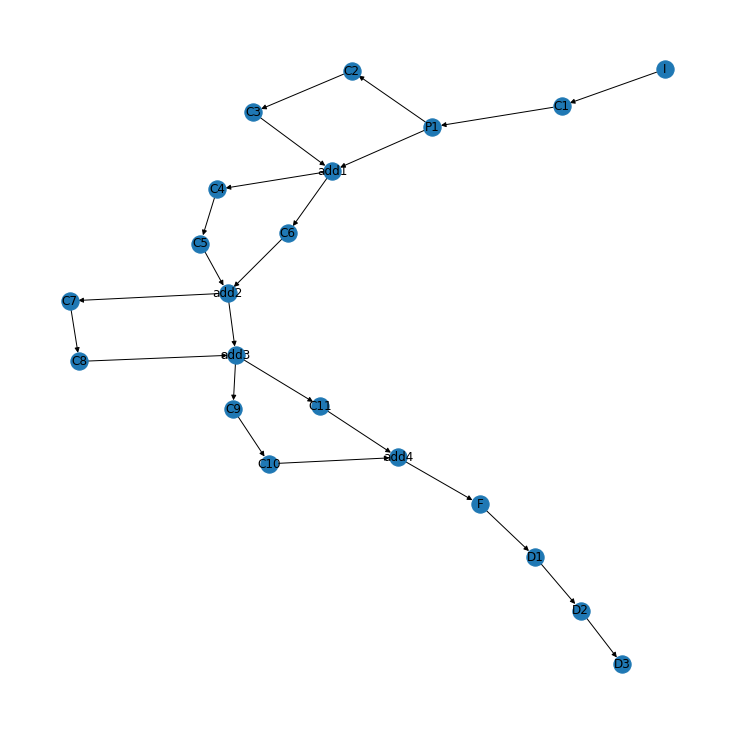

In [249]:
nx.draw_kamada_kawai(G,with_labels=True)

In [250]:
nx.node_link_data(G)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 'I'},
  {'id': 'C1'},
  {'id': 'P1'},
  {'id': 'C2'},
  {'id': 'C3'},
  {'id': 'add1'},
  {'id': 'C4'},
  {'id': 'C5'},
  {'id': 'C6'},
  {'id': 'add2'},
  {'id': 'C7'},
  {'id': 'C8'},
  {'id': 'add3'},
  {'id': 'C9'},
  {'id': 'C10'},
  {'id': 'C11'},
  {'id': 'add4'},
  {'id': 'F'},
  {'id': 'D1'},
  {'id': 'D2'},
  {'id': 'D3'}],
 'links': [{'source': 'I', 'target': 'C1'},
  {'source': 'C1', 'target': 'P1'},
  {'source': 'P1', 'target': 'C2'},
  {'source': 'P1', 'target': 'add1'},
  {'source': 'C2', 'target': 'C3'},
  {'source': 'C3', 'target': 'add1'},
  {'source': 'add1', 'target': 'C4'},
  {'source': 'add1', 'target': 'C6'},
  {'source': 'C4', 'target': 'C4'},
  {'source': 'C4', 'target': 'C5'},
  {'source': 'C5', 'target': 'add2'},
  {'source': 'C6', 'target': 'add2'},
  {'source': 'add2', 'target': 'C7'},
  {'source': 'add2', 'target': 'add3'},
  {'source': 'C7', 'target': 'C7'},
  {'source': 'C7', 'targe

In [252]:
G.nodes

NodeView(('I', 'C1', 'P1', 'C2', 'C3', 'add1', 'C4', 'C5', 'C6', 'add2', 'C7', 'C8', 'add3', 'C9', 'C10', 'C11', 'add4', 'F', 'D1', 'D2', 'D3'))